***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Generate Batch (Wake-Phase On-line)

*Updated:* Feb 8, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * torch.where(q != 0, torch.log(q), -100) + (1-y) * torch.where(1-q != 0, torch.log(1-q), -100)).mean()
    return loss

In [7]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [8]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [9]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [10]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [11]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [12]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [13]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [14]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -100)).sum(axis=1,keepdims=True)
    return H

In [15]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-100)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-100))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [16]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [17]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100) + \
                    (1-p)*torch.where(1-p != 0, torch.log(1-p), -100) - (1-p)*torch.where(1-q != 0, torch.log(1-q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [18]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [19]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [20]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

## Model

In [21]:
dev = torch.device("cpu") # operate on GPU "cuda" or CPU "cpu"

In [22]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [23]:
n_layer = len(n_dz)
n_layer

6

In [24]:
n_d = n_dz[0]
n_d

tensor(12)

In [25]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [26]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [27]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [28]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [29]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011])

In [30]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785])

In [31]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [32]:
len(col_list)

37

### Train Generative with Batch (Wake Phase On-line)

In [47]:
# Analytic_ws_gen_batch = pd.DataFrame(columns=col_list)
# Analytic_ws_gen_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4


In [48]:
# Phi,Theta = para_init(n_dz)

In [67]:
Analytic_ws_gen_batch = pd.read_csv('Analytic_ws_gen_batch.csv', sep=",")
Analytic_ws_gen_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.572849,0.585969,0.621368,0.619785,0.632842,0.598535,0.599493,0.640262,0.641000,27.813496,...,0.034433,3.789535,0.095160,0.033166,1.835547,0.053957,0.005801,1.776885,0.0,0.005955
1,0.237624,0.105303,0.307505,0.140417,0.414395,0.441840,0.116593,0.322713,0.166652,12.659010,...,0.007220,2.036092,0.076201,0.007088,0.441819,0.075975,0.000931,0.451441,0.0,0.001177
2,0.178891,0.068987,0.072189,0.210632,0.399434,0.402951,0.088752,0.071626,0.231786,6.715577,...,0.002326,0.359958,0.037284,0.002505,0.672926,0.044275,0.003512,0.646119,0.0,0.003568
3,0.129345,0.031113,0.029259,0.017588,0.443006,0.311648,0.036083,0.030758,0.015112,13.696703,...,0.000545,0.203194,0.002797,0.000538,0.052699,0.002256,0.000052,0.055237,0.0,0.000068
4,0.127586,0.061613,0.020813,0.021507,0.418018,0.332086,0.076833,0.016788,0.017045,9.596713,...,0.000356,0.112625,0.002019,0.000389,0.067643,0.001717,0.000038,0.064119,0.0,0.000046
5,0.151950,0.020017,0.016154,0.010261,0.390867,0.406765,0.025738,0.015868,0.011589,8.672269,...,0.000141,0.096617,0.000909,0.000143,0.031621,0.000772,0.000009,0.030858,0.0,0.000011
6,0.114091,0.044447,0.011533,0.004772,0.395238,0.352647,0.054509,0.011081,0.000623,6.443364,...,0.000217,0.075854,0.000569,0.000226,0.014234,0.000499,0.000012,0.014703,0.0,0.000009
7,0.101116,0.037711,0.031624,0.004240,0.398451,0.338348,0.041649,0.039243,0.005951,11.485777,...,0.002330,0.178068,0.000804,0.002585,0.012919,0.001046,0.000018,0.011947,0.0,0.000021
8,0.101824,0.091000,0.008481,0.005673,0.388558,0.343154,0.106626,0.009562,0.003306,11.436118,...,0.000131,0.057593,0.001539,0.000124,0.020805,0.001046,0.000058,0.018110,0.0,0.000081
9,0.101452,0.062796,0.056663,0.003479,0.392441,0.348120,0.071929,0.056862,0.000501,11.091152,...,0.001984,0.183221,0.001129,0.002088,0.009181,0.000486,0.000113,0.012632,0.0,0.000091


In [68]:
para = np.load('Parameters_ws_gen_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

D:\Program\anaconda3\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [84]:
batch_size = 100
lr = 0.1
epoch = 1001

In [85]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(n_data):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i]:index[i]+1],lr,dev)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/n_data,'    Loss_sleep:',Loss_S/n_data)
    if e % 100 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/n_data).to('cpu').numpy())
        stat = stat + list((Loss_S/n_data).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_gen_batch.loc[len(Analytic_ws_gen_batch)] = stat

Loss_wake: tensor([0.0000, 0.0776, 0.0063, 0.0012, 0.0007])     Loss_sleep: tensor([3.7146e-01, 3.5735e-01, 8.3888e-03, 1.5255e-03, 7.0164e-05])
Loss_wake: tensor([0.0000, 0.0715, 0.0055, 0.0011, 0.0006])     Loss_sleep: tensor([3.9274e-01, 3.3535e-01, 3.0568e-03, 2.8865e-03, 6.9506e-05])
Loss_wake: tensor([0.0000, 0.0757, 0.0040, 0.0014, 0.0006])     Loss_sleep: tensor([3.8816e-01, 3.4474e-01, 3.2798e-03, 1.3657e-04, 6.8869e-05])
Loss_wake: tensor([0.0000, 0.0697, 0.0038, 0.0013, 0.0009])     Loss_sleep: tensor([0.3851, 0.3402, 0.0032, 0.0015, 0.0034])
Loss_wake: tensor([0.0000, 0.0705, 0.0034, 0.0014, 0.0009])     Loss_sleep: tensor([3.8419e-01, 3.4009e-01, 2.9591e-03, 1.3144e-04, 7.2219e-05])
Loss_wake: tensor([0.0000, 0.0657, 0.0036, 0.0012, 0.0009])     Loss_sleep: tensor([3.9849e-01, 3.2220e-01, 7.2663e-03, 1.5044e-03, 7.1517e-05])
Loss_wake: tensor([0.0000, 0.0651, 0.0039, 0.0012, 0.0004])     Loss_sleep: tensor([3.9441e-01, 3.2657e-01, 4.0719e-03, 1.2724e-04, 7.0820e-05])
Loss_

Loss_wake: tensor([0.0000, 0.0712, 0.0071, 0.0004, 0.0010])     Loss_sleep: tensor([3.6374e-01, 3.6461e-01, 9.3166e-03, 6.3312e-05, 9.3270e-05])
Loss_wake: tensor([0.0000, 0.0720, 0.0081, 0.0006, 0.0008])     Loss_sleep: tensor([3.7499e-01, 3.5610e-01, 1.0442e-02, 6.1770e-05, 9.1902e-05])
Loss_wake: tensor([0.0000, 0.0650, 0.0109, 0.0007, 0.0006])     Loss_sleep: tensor([3.7465e-01, 3.4496e-01, 1.6609e-02, 6.0328e-05, 9.0596e-05])
Loss_wake: tensor([0.0000, 0.0639, 0.0143, 0.0005, 0.0014])     Loss_sleep: tensor([3.7004e-01, 3.4252e-01, 1.9675e-02, 6.5787e-05, 3.8817e-03])
Loss_wake: tensor([0.0000, 0.0664, 0.0217, 0.0005, 0.0007])     Loss_sleep: tensor([3.7139e-01, 3.4196e-01, 3.0106e-02, 5.7951e-05, 3.2422e-03])
Loss_wake: tensor([0.0000, 0.0656, 0.0135, 0.0005, 0.0011])     Loss_sleep: tensor([3.7411e-01, 3.4081e-01, 1.2193e-02, 5.6424e-05, 9.4674e-05])
Loss_wake: tensor([0.0000, 0.0549, 0.0099, 0.0005, 0.0010])     Loss_sleep: tensor([3.7865e-01, 3.2338e-01, 1.2759e-02, 1.9271e-03

Loss_wake: tensor([0.0000, 0.0621, 0.0122, 0.0005, 0.0009])     Loss_sleep: tensor([3.8631e-01, 3.3105e-01, 1.6364e-02, 6.1318e-05, 1.0345e-04])
Loss_wake: tensor([0.0000, 0.0471, 0.0204, 0.0009, 0.0008])     Loss_sleep: tensor([3.8950e-01, 3.0570e-01, 2.5260e-02, 6.0030e-05, 1.0168e-04])
Loss_wake: tensor([0.0000, 0.0429, 0.0323, 0.0005, 0.0011])     Loss_sleep: tensor([3.8931e-01, 3.0141e-01, 3.7869e-02, 5.8813e-05, 1.0000e-04])
Loss_wake: tensor([0.0000, 0.0395, 0.0265, 0.0007, 0.0011])     Loss_sleep: tensor([3.9166e-01, 2.9806e-01, 3.2663e-02, 5.7669e-05, 9.8367e-05])
Loss_wake: tensor([0.0000, 0.0416, 0.0554, 0.0007, 0.0011])     Loss_sleep: tensor([3.8598e-01, 2.9219e-01, 7.5426e-02, 5.6572e-05, 9.6813e-05])
Loss_wake: tensor([0.0000, 0.0415, 0.0326, 0.0005, 0.0012])     Loss_sleep: tensor([3.8990e-01, 3.0091e-01, 3.9032e-02, 5.5528e-05, 9.5299e-05])
Loss_wake: tensor([0.0000, 0.0414, 0.0516, 0.0006, 0.0012])     Loss_sleep: tensor([3.8687e-01, 2.9079e-01, 7.4164e-02, 5.5043e-05

Loss_wake: tensor([0.0000, 0.0583, 0.0102, 0.0006, 0.0012])     Loss_sleep: tensor([0.3773, 0.3310, 0.0133, 0.0023, 0.0039])
Loss_wake: tensor([0.0000, 0.0632, 0.0158, 0.0004, 0.0013])     Loss_sleep: tensor([3.7276e-01, 3.3866e-01, 2.0894e-02, 5.3560e-05, 1.2084e-04])
Loss_wake: tensor([0.0000, 0.0735, 0.0219, 0.0006, 0.0008])     Loss_sleep: tensor([3.6685e-01, 3.5900e-01, 2.5782e-02, 5.2689e-05, 1.1840e-04])
Loss_wake: tensor([0.0000, 0.0699, 0.0226, 0.0006, 0.0008])     Loss_sleep: tensor([3.7217e-01, 3.4604e-01, 3.0913e-02, 5.2538e-05, 3.1488e-03])
Loss_wake: tensor([0.0000, 0.0573, 0.0281, 0.0007, 0.0013])     Loss_sleep: tensor([3.7963e-01, 3.2118e-01, 3.4240e-02, 1.7053e-03, 1.2281e-04])
Loss_wake: tensor([0.0000, 0.0584, 0.0155, 0.0006, 0.0014])     Loss_sleep: tensor([3.7860e-01, 3.2983e-01, 1.9439e-02, 5.4670e-05, 1.2026e-04])
Loss_wake: tensor([0.0000, 0.0707, 0.0290, 0.0005, 0.0012])     Loss_sleep: tensor([3.7676e-01, 3.4472e-01, 3.8150e-02, 5.3708e-05, 1.1783e-04])
Loss_

Loss_wake: tensor([0.0000, 0.0332, 0.0161, 0.0006, 0.0018])     Loss_sleep: tensor([3.8506e-01, 2.7762e-01, 3.9241e-02, 5.7212e-05, 3.0436e-03])
Loss_wake: tensor([0.0000, 0.0362, 0.0109, 0.0007, 0.0018])     Loss_sleep: tensor([3.8288e-01, 2.9384e-01, 2.6133e-02, 5.5441e-05, 1.8502e-04])
Loss_wake: tensor([0.0000, 0.0359, 0.0113, 0.0007, 0.0013])     Loss_sleep: tensor([3.8277e-01, 2.8806e-01, 2.3949e-02, 5.4476e-05, 1.7897e-04])
Loss_wake: tensor([0.0000, 0.0345, 0.0121, 0.0007, 0.0013])     Loss_sleep: tensor([3.8489e-01, 2.7938e-01, 3.1780e-02, 5.3145e-03, 1.7338e-04])
Loss_wake: tensor([0.0000, 0.0360, 0.0102, 0.0006, 0.0015])     Loss_sleep: tensor([3.8467e-01, 2.8965e-01, 2.3244e-02, 6.1830e-05, 1.6819e-04])
Loss_wake: tensor([0.0000, 0.0326, 0.0065, 0.0006, 0.0014])     Loss_sleep: tensor([3.8504e-01, 2.8954e-01, 1.1510e-02, 7.6811e-05, 6.7799e-03])
Loss_wake: tensor([0.0000, 0.0326, 0.0049, 0.0005, 0.0014])     Loss_sleep: tensor([3.8770e-01, 2.8836e-01, 7.4908e-03, 5.9337e-05

Loss_wake: tensor([0.0000, 0.0348, 0.0082, 0.0007, 0.0024])     Loss_sleep: tensor([3.8817e-01, 2.8715e-01, 1.8585e-02, 6.2777e-05, 2.9472e-03])
Loss_wake: tensor([0.0000, 0.0334, 0.0098, 0.0006, 0.0024])     Loss_sleep: tensor([3.8616e-01, 2.7953e-01, 2.3811e-02, 6.7337e-05, 3.9193e-03])
Loss_wake: tensor([0.0000, 0.0355, 0.0091, 0.0005, 0.0022])     Loss_sleep: tensor([3.8541e-01, 2.9090e-01, 1.8223e-02, 6.0215e-05, 2.9527e-03])
Loss_wake: tensor([0.0000, 0.0367, 0.0070, 0.0006, 0.0025])     Loss_sleep: tensor([0.3833, 0.2964, 0.0126, 0.0017, 0.0029])
Loss_wake: tensor([0.0000, 0.0321, 0.0073, 0.0006, 0.0026])     Loss_sleep: tensor([0.3863, 0.2843, 0.0137, 0.0018, 0.0029])
Loss_wake: tensor([0.0000, 0.0346, 0.0095, 0.0007, 0.0028])     Loss_sleep: tensor([3.8824e-01, 2.8606e-01, 2.2850e-02, 6.4524e-05, 2.8826e-04])
Loss_wake: tensor([0.0000, 0.0342, 0.0298, 0.0005, 0.0023])     Loss_sleep: tensor([3.8748e-01, 2.8017e-01, 5.1062e-02, 6.3968e-05, 2.9494e-03])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0719, 0.0055, 0.0007, 0.0027])     Loss_sleep: tensor([3.6083e-01, 3.6207e-01, 1.0922e-02, 7.0006e-05, 2.9611e-03])
Loss_wake: tensor([0.0000, 0.0736, 0.0052, 0.0006, 0.0026])     Loss_sleep: tensor([3.6303e-01, 3.5944e-01, 1.3839e-02, 7.3865e-05, 3.7927e-03])
Loss_wake: tensor([0.0000, 0.0777, 0.0079, 0.0006, 0.0026])     Loss_sleep: tensor([0.3679, 0.3576, 0.0141, 0.0017, 0.0056])
Loss_wake: tensor([0.0000, 0.0742, 0.0065, 0.0007, 0.0026])     Loss_sleep: tensor([3.7238e-01, 3.4903e-01, 1.2021e-02, 1.9016e-03, 2.9907e-04])
Loss_wake: tensor([0.0000, 0.0777, 0.0065, 0.0007, 0.0023])     Loss_sleep: tensor([3.6203e-01, 3.6283e-01, 1.4169e-02, 6.9551e-05, 2.8205e-04])
Loss_wake: tensor([0.0000, 0.0602, 0.0077, 0.0004, 0.0023])     Loss_sleep: tensor([3.6898e-01, 3.3482e-01, 1.8331e-02, 6.8029e-05, 2.6708e-04])
Loss_wake: tensor([0.0000, 0.0608, 0.0082, 0.0007, 0.0025])     Loss_sleep: tensor([3.7079e-01, 3.3092e-01, 2.0789e-02, 6.6585e-05, 2.5382e-04])
Loss_

Loss_wake: tensor([0.0000, 0.0821, 0.0036, 0.0009, 0.0018])     Loss_sleep: tensor([0.3724, 0.3624, 0.0076, 0.0017, 0.0038])
Loss_wake: tensor([0.0000, 0.0562, 0.0036, 0.0007, 0.0018])     Loss_sleep: tensor([0.3747, 0.3282, 0.0090, 0.0018, 0.0059])
Loss_wake: tensor([0.0000, 0.0409, 0.0060, 0.0007, 0.0018])     Loss_sleep: tensor([3.7766e-01, 3.0869e-01, 9.0206e-03, 7.7469e-05, 2.0871e-04])
Loss_wake: tensor([0.0000, 0.0387, 0.0048, 0.0006, 0.0020])     Loss_sleep: tensor([3.8511e-01, 2.9823e-01, 9.0503e-03, 1.9130e-03, 2.0109e-04])
Loss_wake: tensor([0.0000, 0.0361, 0.0069, 0.0008, 0.0018])     Loss_sleep: tensor([3.8604e-01, 2.9031e-01, 1.7583e-02, 4.9386e-03, 1.9411e-04])
Loss_wake: tensor([0.0000, 0.0393, 0.0076, 0.0008, 0.0022])     Loss_sleep: tensor([3.8421e-01, 2.9486e-01, 1.6450e-02, 5.5054e-03, 1.8766e-04])
Loss_wake: tensor([0.0000, 0.0417, 0.0071, 0.0011, 0.0017])     Loss_sleep: tensor([0.3846, 0.2986, 0.0142, 0.0017, 0.0030])
Loss_wake: tensor([0.0000, 0.0411, 0.0056, 0.

Loss_wake: tensor([0.0000, 0.0587, 0.0074, 0.0008, 0.0013])     Loss_sleep: tensor([3.7207e-01, 3.2744e-01, 2.5657e-02, 8.8109e-05, 1.5189e-04])
Loss_wake: tensor([0.0000, 0.0680, 0.0070, 0.0010, 0.0014])     Loss_sleep: tensor([3.6167e-01, 3.5232e-01, 1.5903e-02, 8.8897e-05, 6.0558e-03])
Loss_wake: tensor([0.0000, 0.0685, 0.0071, 0.0011, 0.0018])     Loss_sleep: tensor([3.5834e-01, 3.5678e-01, 1.7224e-02, 3.2533e-03, 1.6740e-04])
Loss_wake: tensor([0.0000, 0.0684, 0.0066, 0.0011, 0.0012])     Loss_sleep: tensor([3.6714e-01, 3.5245e-01, 1.5224e-02, 9.3421e-05, 1.6304e-04])
Loss_wake: tensor([0.0000, 0.0655, 0.0074, 0.0010, 0.0016])     Loss_sleep: tensor([3.7248e-01, 3.3643e-01, 2.2454e-02, 1.6092e-03, 1.5894e-04])
Loss_wake: tensor([0.0000, 0.0622, 0.0075, 0.0007, 0.0013])     Loss_sleep: tensor([3.6856e-01, 3.3561e-01, 1.7266e-02, 9.6079e-05, 1.5509e-04])
Loss_wake: tensor([0.0000, 0.0509, 0.0077, 0.0009, 0.0013])     Loss_sleep: tensor([3.8215e-01, 3.0007e-01, 3.3431e-02, 9.2495e-05

Loss_wake: tensor([0.0000, 0.0466, 0.0048, 0.0012, 0.0012])     Loss_sleep: tensor([0.3853, 0.3062, 0.0083, 0.0034, 0.0031])
Loss_wake: tensor([0.0000, 0.0480, 0.0031, 0.0014, 0.0016])     Loss_sleep: tensor([3.8290e-01, 3.1176e-01, 6.8650e-03, 3.3925e-03, 1.4655e-04])
Loss_wake: tensor([0.0000, 0.0605, 0.0048, 0.0012, 0.0012])     Loss_sleep: tensor([3.7821e-01, 3.2982e-01, 1.1529e-02, 1.9967e-03, 1.4328e-04])
Loss_wake: tensor([0.0000, 0.0803, 0.0057, 0.0012, 0.0013])     Loss_sleep: tensor([3.6344e-01, 3.6127e-01, 1.1378e-02, 1.4146e-04, 1.4018e-04])
Loss_wake: tensor([0.0000, 0.0838, 0.0048, 0.0012, 0.0015])     Loss_sleep: tensor([3.5705e-01, 3.7801e-01, 9.0824e-03, 1.3504e-04, 3.1345e-03])
Loss_wake: tensor([0.0000, 0.0809, 0.0057, 0.0012, 0.0013])     Loss_sleep: tensor([0.3695, 0.3590, 0.0148, 0.0015, 0.0031])
Loss_wake: tensor([0.0000, 0.0854, 0.0069, 0.0015, 0.0014])     Loss_sleep: tensor([3.6425e-01, 3.6944e-01, 1.5995e-02, 3.2008e-03, 1.5152e-04])
Loss_wake: tensor([0.0000

Loss_wake: tensor([0.0000, 0.0821, 0.0048, 0.0017, 0.0014])     Loss_sleep: tensor([0.3869, 0.3432, 0.0129, 0.0015, 0.0031])
Loss_wake: tensor([0.0000, 0.0912, 0.0060, 0.0016, 0.0014])     Loss_sleep: tensor([3.7972e-01, 3.5526e-01, 1.5404e-02, 1.5108e-03, 1.5997e-04])
Loss_wake: tensor([0.0000, 0.0873, 0.0053, 0.0015, 0.0017])     Loss_sleep: tensor([3.7402e-01, 3.5984e-01, 1.4967e-02, 6.3136e-03, 1.5569e-04])
Loss_wake: tensor([0.0000, 0.0830, 0.0062, 0.0016, 0.0016])     Loss_sleep: tensor([3.7244e-01, 3.5303e-01, 2.0672e-02, 1.8166e-03, 1.5167e-04])
Loss_wake: tensor([0.0000, 0.0904, 0.0068, 0.0013, 0.0013])     Loss_sleep: tensor([3.7584e-01, 3.6274e-01, 1.6267e-02, 1.8036e-04, 3.7073e-03])
Loss_wake: tensor([0.0000, 0.0921, 0.0075, 0.0013, 0.0014])     Loss_sleep: tensor([0.3793, 0.3504, 0.0260, 0.0020, 0.0031])
Loss_wake: tensor([0.0000, 0.0791, 0.0079, 0.0015, 0.0012])     Loss_sleep: tensor([0.3893, 0.3261, 0.0277, 0.0029, 0.0031])
Loss_wake: tensor([0.0000, 0.0724, 0.0072, 0.

Loss_wake: tensor([0.0000, 0.0399, 0.0022, 0.0015, 0.0011])     Loss_sleep: tensor([3.7665e-01, 3.0867e-01, 2.0519e-03, 1.7282e-03, 1.2598e-04])
Loss_wake: tensor([0.0000, 0.0383, 0.0023, 0.0014, 0.0011])     Loss_sleep: tensor([3.7926e-01, 3.0941e-01, 6.7886e-03, 1.5436e-03, 1.2377e-04])
Loss_wake: tensor([0.0000, 0.0444, 0.0021, 0.0015, 0.0012])     Loss_sleep: tensor([3.8015e-01, 3.1396e-01, 2.9030e-03, 1.5358e-03, 1.2165e-04])
Loss_wake: tensor([0.0000, 0.0410, 0.0022, 0.0016, 0.0009])     Loss_sleep: tensor([3.8647e-01, 3.0596e-01, 2.8922e-03, 1.6677e-04, 1.1962e-04])
Loss_wake: tensor([0.0000, 0.0412, 0.0022, 0.0017, 0.0009])     Loss_sleep: tensor([3.8323e-01, 3.0158e-01, 3.4474e-03, 2.8832e-03, 1.1766e-04])
Loss_wake: tensor([0.0000, 0.0442, 0.0022, 0.0015, 0.0011])     Loss_sleep: tensor([0.3793, 0.3128, 0.0037, 0.0018, 0.0070])
Loss_wake: tensor([0.0000, 0.0416, 0.0023, 0.0017, 0.0013])     Loss_sleep: tensor([3.7946e-01, 3.0608e-01, 3.6873e-03, 1.5310e-03, 1.2295e-04])
Loss_

Loss_wake: tensor([0.0000, 0.0405, 0.0017, 0.0008, 0.0021])     Loss_sleep: tensor([3.7781e-01, 3.0903e-01, 4.3570e-03, 9.1140e-05, 5.9079e-03])
Loss_wake: tensor([0.0000, 0.0428, 0.0020, 0.0006, 0.0015])     Loss_sleep: tensor([3.8296e-01, 3.0953e-01, 4.1460e-03, 8.5142e-05, 2.0053e-04])
Loss_wake: tensor([0.0000, 0.0471, 0.0020, 0.0008, 0.0014])     Loss_sleep: tensor([3.8086e-01, 3.1289e-01, 4.4945e-03, 1.6365e-03, 1.9373e-04])
Loss_wake: tensor([0.0000, 0.0499, 0.0019, 0.0012, 0.0016])     Loss_sleep: tensor([0.3805, 0.3159, 0.0015, 0.0033, 0.0036])
Loss_wake: tensor([0.0000, 0.0467, 0.0016, 0.0010, 0.0014])     Loss_sleep: tensor([3.8639e-01, 3.0925e-01, 2.4137e-04, 1.5992e-03, 1.8481e-04])
Loss_wake: tensor([0.0000, 0.0414, 0.0015, 0.0013, 0.0015])     Loss_sleep: tensor([3.8640e-01, 3.0288e-01, 2.1162e-03, 1.0742e-04, 3.0636e-03])
Loss_wake: tensor([0.0000, 0.0380, 0.0016, 0.0010, 0.0016])     Loss_sleep: tensor([3.8832e-01, 2.9561e-01, 2.0998e-03, 3.2899e-03, 1.8743e-04])
Loss_

Loss_wake: tensor([0.0000, 0.0929, 0.0008, 0.0026, 0.0011])     Loss_sleep: tensor([3.6649e-01, 3.7785e-01, 1.3433e-03, 1.5191e-03, 1.2327e-04])
Loss_wake: tensor([0.0000, 0.0698, 0.0008, 0.0023, 0.0011])     Loss_sleep: tensor([3.8417e-01, 3.3532e-01, 2.3490e-03, 2.5979e-04, 1.2139e-04])
Loss_wake: tensor([0.0000, 0.0550, 0.0009, 0.0022, 0.0010])     Loss_sleep: tensor([3.8832e-01, 3.1364e-01, 1.0479e-04, 2.2158e-04, 1.1961e-04])
Loss_wake: tensor([0.0000, 0.0480, 0.0009, 0.0018, 0.0010])     Loss_sleep: tensor([3.8734e-01, 3.0899e-01, 2.4340e-03, 3.1021e-03, 1.1785e-04])
Loss_wake: tensor([0.0000, 0.0441, 0.0009, 0.0017, 0.0011])     Loss_sleep: tensor([3.8770e-01, 3.0188e-01, 1.1131e-04, 2.0370e-04, 1.1618e-04])
Loss_wake: tensor([0.0000, 0.0521, 0.0009, 0.0014, 0.0009])     Loss_sleep: tensor([3.9587e-01, 3.0248e-01, 2.3990e-03, 1.9066e-04, 3.4587e-03])
Loss_wake: tensor([0.0000, 0.0529, 0.0010, 0.0017, 0.0012])     Loss_sleep: tensor([3.9099e-01, 3.0733e-01, 1.1908e-03, 1.5261e-03

Loss_wake: tensor([0.0000, 0.0791, 0.0007, 0.0013, 0.0011])     Loss_sleep: tensor([3.7755e-01, 3.5170e-01, 8.2569e-05, 2.0012e-03, 1.2193e-04])
Loss_wake: tensor([0.0000, 0.0600, 0.0007, 0.0010, 0.0011])     Loss_sleep: tensor([3.9204e-01, 3.1813e-01, 7.9229e-05, 1.3214e-04, 1.2014e-04])
Loss_wake: tensor([0.0000, 0.0564, 0.0006, 0.0010, 0.0010])     Loss_sleep: tensor([3.9503e-01, 3.0682e-01, 1.5013e-03, 1.2424e-04, 1.1839e-04])
Loss_wake: tensor([0.0000, 0.0577, 0.0006, 0.0014, 0.0009])     Loss_sleep: tensor([3.9443e-01, 3.1059e-01, 7.5100e-05, 1.1746e-04, 1.1674e-04])
Loss_wake: tensor([0.0000, 0.0563, 0.0006, 0.0009, 0.0011])     Loss_sleep: tensor([0.3906, 0.3123, 0.0013, 0.0019, 0.0033])
Loss_wake: tensor([0.0000, 0.0563, 0.0007, 0.0009, 0.0012])     Loss_sleep: tensor([3.8207e-01, 3.2280e-01, 7.8047e-05, 1.5713e-03, 1.1994e-04])
Loss_wake: tensor([0.0000, 0.0666, 0.0006, 0.0014, 0.0013])     Loss_sleep: tensor([3.7913e-01, 3.3879e-01, 7.5600e-05, 1.5635e-03, 3.4376e-03])
Loss_

Loss_wake: tensor([0.0000, 0.0749, 0.0006, 0.0007, 0.0009])     Loss_sleep: tensor([3.6617e-01, 3.6018e-01, 5.2900e-05, 9.1884e-05, 3.5032e-03])
Loss_wake: tensor([0.0000, 0.0755, 0.0004, 0.0008, 0.0014])     Loss_sleep: tensor([3.6706e-01, 3.6120e-01, 5.1698e-05, 8.2610e-05, 1.0658e-04])
Loss_wake: tensor([0.0000, 0.0713, 0.0004, 0.0008, 0.0010])     Loss_sleep: tensor([3.6802e-01, 3.5929e-01, 1.3664e-03, 7.9934e-05, 1.0524e-04])
Loss_wake: tensor([0.0000, 0.0652, 0.0004, 0.0007, 0.0009])     Loss_sleep: tensor([3.7579e-01, 3.4206e-01, 5.2538e-05, 7.7473e-05, 1.0394e-04])
Loss_wake: tensor([0.0000, 0.0704, 0.0005, 0.0008, 0.0010])     Loss_sleep: tensor([3.6746e-01, 3.5631e-01, 5.8323e-05, 3.4502e-03, 1.0267e-04])
Loss_wake: tensor([0.0000, 0.0827, 0.0006, 0.0008, 0.0010])     Loss_sleep: tensor([3.6792e-01, 3.7073e-01, 3.8106e-03, 8.2843e-05, 1.0143e-04])
Loss_wake: tensor([0.0000, 0.0597, 0.0007, 0.0006, 0.0011])     Loss_sleep: tensor([3.8291e-01, 3.2241e-01, 6.6362e-05, 1.6031e-03

Loss_wake: tensor([0.0000, 0.0847, 0.0005, 0.0008, 0.0010])     Loss_sleep: tensor([3.6585e-01, 3.7154e-01, 1.2946e-03, 7.3553e-05, 1.0752e-04])
Loss_wake: tensor([0.0000, 0.0797, 0.0005, 0.0008, 0.0009])     Loss_sleep: tensor([3.7370e-01, 3.6060e-01, 5.8255e-05, 1.7158e-03, 1.0611e-04])
Loss_wake: tensor([0.0000, 0.0752, 0.0005, 0.0008, 0.0008])     Loss_sleep: tensor([3.6851e-01, 3.5671e-01, 5.5900e-05, 7.4629e-05, 1.0476e-04])
Loss_wake: tensor([0.0000, 0.0578, 0.0006, 0.0008, 0.0010])     Loss_sleep: tensor([3.7375e-01, 3.3186e-01, 5.6848e-05, 1.6600e-03, 1.0343e-04])
Loss_wake: tensor([0.0000, 0.0572, 0.0007, 0.0007, 0.0009])     Loss_sleep: tensor([3.7466e-01, 3.3354e-01, 2.5635e-03, 7.7244e-05, 1.0212e-04])
Loss_wake: tensor([0.0000, 0.0557, 0.0006, 0.0008, 0.0008])     Loss_sleep: tensor([3.7263e-01, 3.3154e-01, 1.2622e-03, 7.5128e-05, 1.0088e-04])
Loss_wake: tensor([0.0000, 0.0556, 0.0007, 0.0008, 0.0011])     Loss_sleep: tensor([3.7138e-01, 3.3435e-01, 1.3012e-03, 1.7063e-03

Loss_wake: tensor([0.0000, 0.0784, 0.0005, 0.0007, 0.0012])     Loss_sleep: tensor([3.6274e-01, 3.6501e-01, 4.4607e-05, 6.8688e-05, 9.9965e-05])
Loss_wake: tensor([0.0000, 0.0642, 0.0005, 0.0007, 0.0011])     Loss_sleep: tensor([3.6958e-01, 3.4432e-01, 4.3783e-05, 7.3274e-05, 3.5190e-03])
Loss_wake: tensor([0.0000, 0.0654, 0.0004, 0.0007, 0.0013])     Loss_sleep: tensor([3.7442e-01, 3.3928e-01, 4.2989e-05, 7.1856e-05, 3.4878e-03])
Loss_wake: tensor([0.0000, 0.0606, 0.0004, 0.0005, 0.0010])     Loss_sleep: tensor([3.6574e-01, 3.4167e-01, 1.5053e-03, 6.4663e-05, 1.0292e-04])
Loss_wake: tensor([0.0000, 0.0553, 0.0004, 0.0007, 0.0009])     Loss_sleep: tensor([3.8245e-01, 3.2425e-01, 1.4026e-03, 6.3478e-05, 1.0165e-04])
Loss_wake: tensor([0.0000, 0.0569, 0.0003, 0.0007, 0.0008])     Loss_sleep: tensor([3.7554e-01, 3.2804e-01, 4.8047e-05, 1.8483e-03, 1.0038e-04])
Loss_wake: tensor([0.0000, 0.0725, 0.0004, 0.0007, 0.0012])     Loss_sleep: tensor([3.6626e-01, 3.6014e-01, 4.3336e-05, 6.3479e-05

In [86]:
Analytic_ws_gen_batch

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Recog_D_KL_Layer_0,...,Recog_D_KL_Layer_3,Gen_H_Layer_3,Gen_I_Layer_3,Gen_D_KL_Layer_3,Recog_H_Layer_4,Recog_I_Layer_4,Recog_D_KL_Layer_4,Gen_H_Layer_4,Gen_I_Layer_4,Gen_D_KL_Layer_4
0,0.572849,0.585969,0.621368,0.619785,0.632842,0.598535,0.599493,0.640262,0.641000,27.813496,...,0.034433,3.789535,0.095160,0.033166,1.835547,0.053957,0.005801,1.776885,0.0,0.005955
1,0.237624,0.105303,0.307505,0.140417,0.414395,0.441840,0.116593,0.322713,0.166652,12.659010,...,0.007220,2.036092,0.076201,0.007088,0.441819,0.075975,0.000931,0.451441,0.0,0.001177
2,0.178891,0.068987,0.072189,0.210632,0.399434,0.402951,0.088752,0.071626,0.231786,6.715577,...,0.002326,0.359958,0.037284,0.002505,0.672926,0.044275,0.003512,0.646119,0.0,0.003568
3,0.129345,0.031113,0.029259,0.017588,0.443006,0.311648,0.036083,0.030758,0.015112,13.696703,...,0.000545,0.203194,0.002797,0.000538,0.052699,0.002256,0.000052,0.055237,0.0,0.000068
4,0.127586,0.061613,0.020813,0.021507,0.418018,0.332086,0.076833,0.016788,0.017045,9.596713,...,0.000356,0.112625,0.002019,0.000389,0.067643,0.001717,0.000038,0.064119,0.0,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.082015,0.004867,0.001255,0.001722,0.370837,0.356350,0.011435,0.000157,0.000152,9.180554,...,0.000019,0.008331,0.000052,0.000018,0.004491,0.000055,0.000007,0.004267,0.0,0.000004
117,0.042792,0.001998,0.000610,0.001454,0.382960,0.309532,0.004146,0.000085,0.000201,8.304753,...,0.000012,0.005099,0.000038,0.000017,0.004717,0.000034,0.000011,0.005364,0.0,0.000009
118,0.041648,0.000922,0.001501,0.001266,0.384542,0.301525,0.000098,0.000156,0.006824,6.708382,...,0.000016,0.007610,0.000043,0.000022,0.003264,0.000047,0.000003,0.003494,0.0,0.000003
119,0.040790,0.000600,0.000836,0.001235,0.391275,0.301008,0.001413,0.000085,0.000104,8.861288,...,0.000006,0.005032,0.000031,0.000003,0.003149,0.000019,0.000002,0.003110,0.0,-0.000001


In [83]:
# Analytic_ws_online.dtypes

In [87]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [88]:
np.save('Parameters_ws_gen_batch',parameters)

In [89]:
Analytic_ws_gen_batch.to_csv('Analytic_ws_gen_batch.csv', index = False)

In [90]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ft['Layer 0: dist'] = data_dist_ft
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data Distribution D_KL: 9.1304
Layer 0 Generative  Distribution D_KL: 0.3676 H(Y): 6.7347 H(Y|X): 4.1737 I_XY: 2.561
Layer 1 Recognition Distribution D_KL: 0.1017 H(Y): 3.0171 H(Y|X): 0.522 I_XY: 2.4952
Layer 1 Generative  Distribution D_KL: 0.1035 H(Y): 3.0833 H(Y|X): 3.0828 I_XY: 0.0004
Layer 2 Recognition Distribution D_KL: 0.0 H(Y): 0.0052 H(Y|X): 0.0046 I_XY: 0.0006
Layer 2 Generative  Distribution D_KL: 0.0001 H(Y): 0.004 H(Y|X): 0.0039 I_XY: 0.0
Layer 3 Recognition Distribution D_KL: 0.0 H(Y): 0.0041 H(Y|X): 0.0041 I_XY: 0.0
Layer 3 Generative  Distribution D_KL: 0.0 H(Y): 0.0041 H(Y|X): 0.0041 I_XY: 0.0
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 0.003 H(Y|X): 0.003 I_XY: 0.0
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 0.0028 H(Y|X): 0.0028 I_XY: 0.0


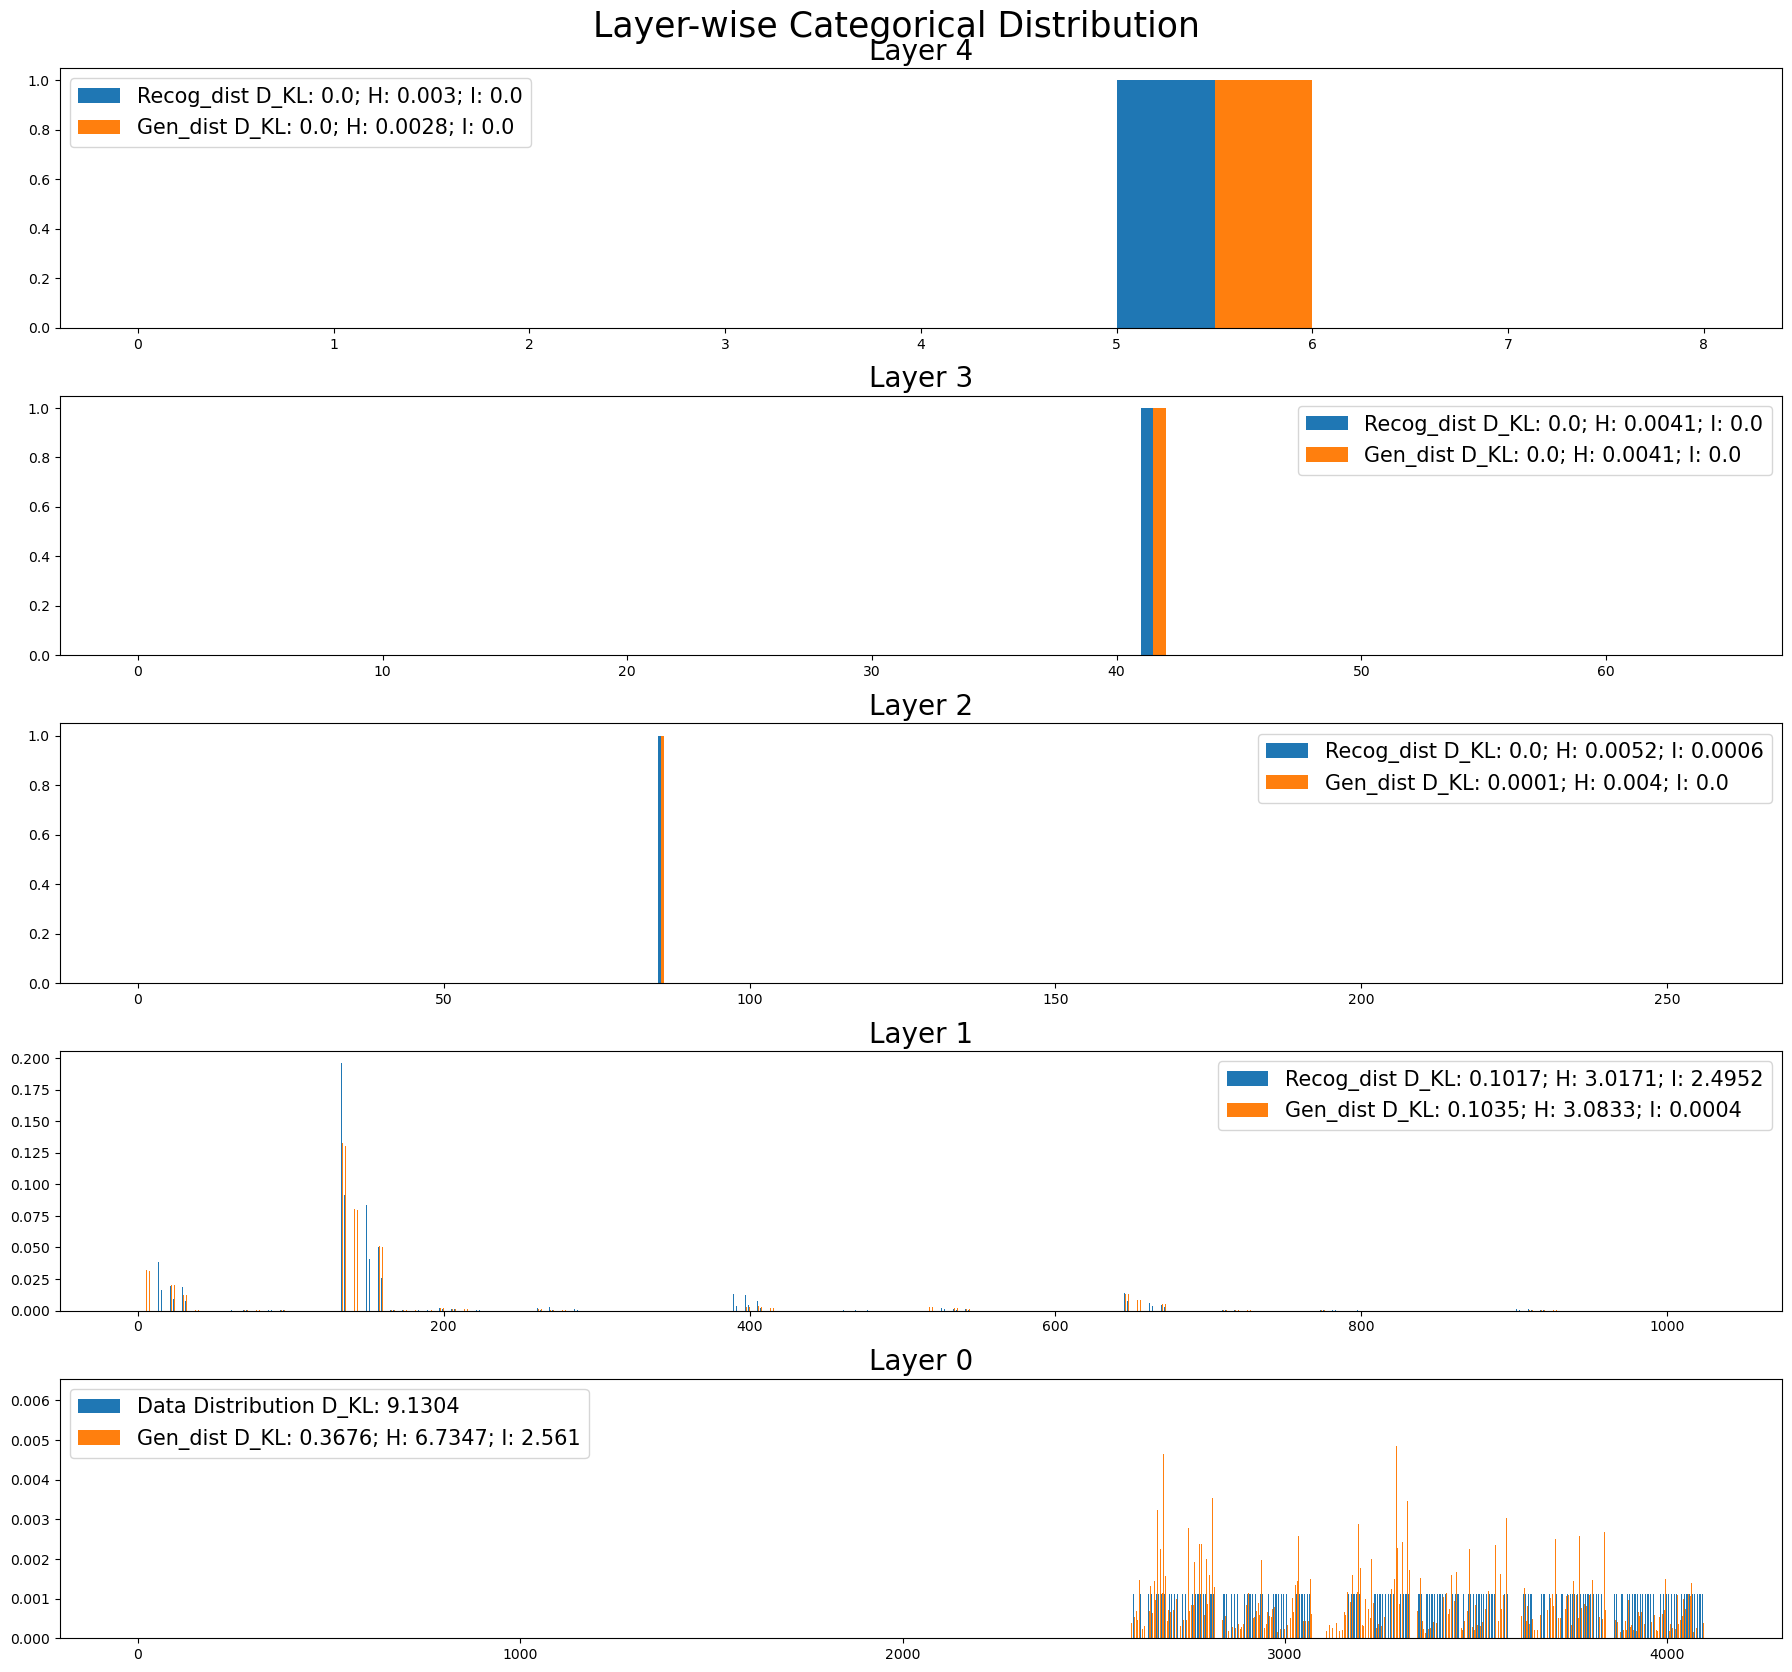

In [91]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
    H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
    H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
    I_s = H_Y_s - H_YX_s
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i == 0:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        print("Layer "+str(i), "Data Distribution D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data Distribution D_KL: " + str(np.around(D_KL_w,4)))
    else:
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
    ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
plt.tight_layout(pad=1)    
plt.show()

In [110]:
# fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
# fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
# for i in range(n_layer-1):
#     dist_s = sleep_ft['Layer '+str(i)+': dist']
#     dist_w = wake_ft['Layer '+str(i)+': dist']
    
#     if i > 0:
#         H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
#         H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
#         I_w = H_Y_w - H_YX_w
#         D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
#         print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
#           "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
#     H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
#     H_YX_s = sleep_ft['Layer '+str(i)+': H_YX'].item()
#     I_s = H_Y_s - H_YX_s
#     D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
#     if i == 0:
#         D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
#         print("Layer "+str(i), "Data Distribution D_KL: "+str(np.around(D_KL_w,4)))
#         ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
#                            label = "Data Distribution D_KL: " + str(np.around(D_KL_w,4)))
#     else:
#         ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
#                            label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
#                                str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
    
#     ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
#                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
#                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
#     ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
#     ax_ct[n_layer-2-i].legend(fontsize=15)
    
#     print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
#           "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
# plt.tight_layout(pad=1)    
# plt.show()

### Plot Analytic

In [80]:
# Analytic_ws_gen_batch['Index'] = Analytic_ws_gen_batch.index

In [42]:
# for i in range(len(col_list)):
#     Analytic_ws_gen_batch.plot(x='Index',y=col_list[i],kind='line',legend=True)
# plt.close()

In [92]:
x = np.arange(len(Analytic_ws_gen_batch))

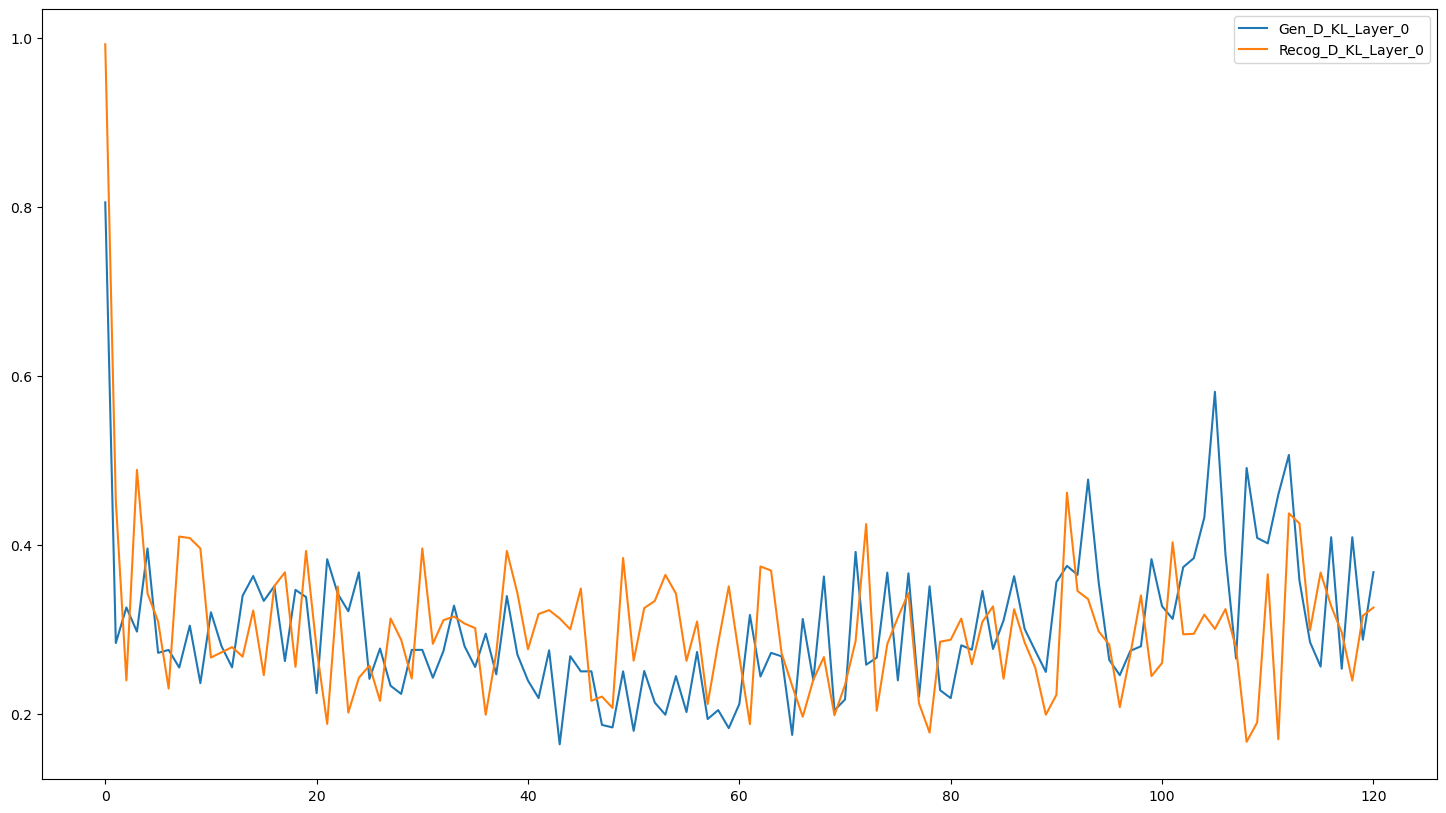

In [93]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_gen_batch['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_gen_batch['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

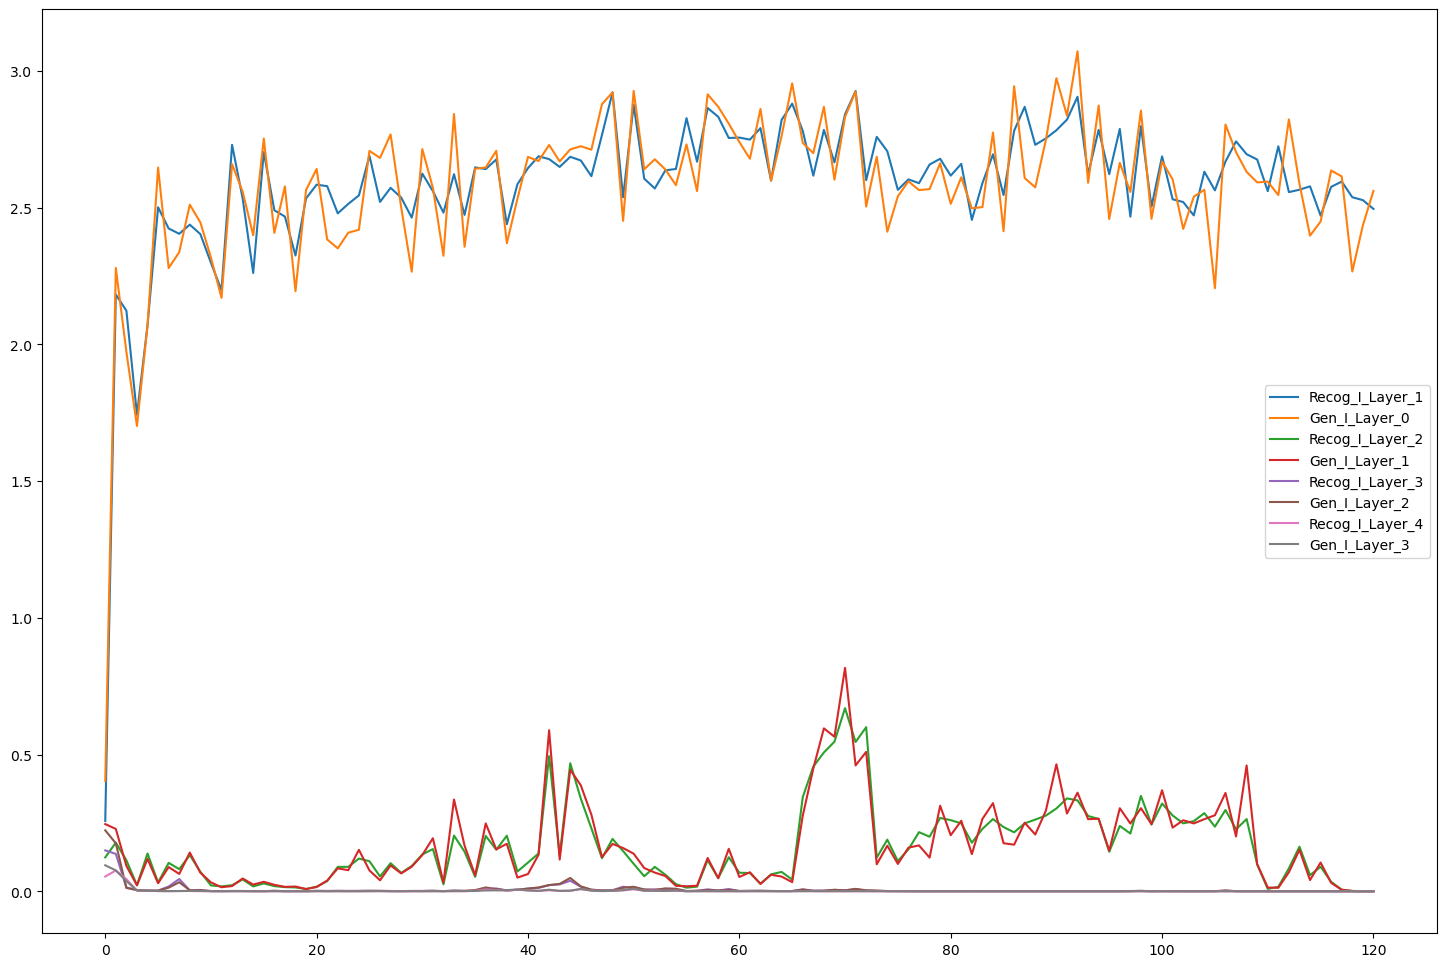

In [94]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_gen_batch['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_gen_batch['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

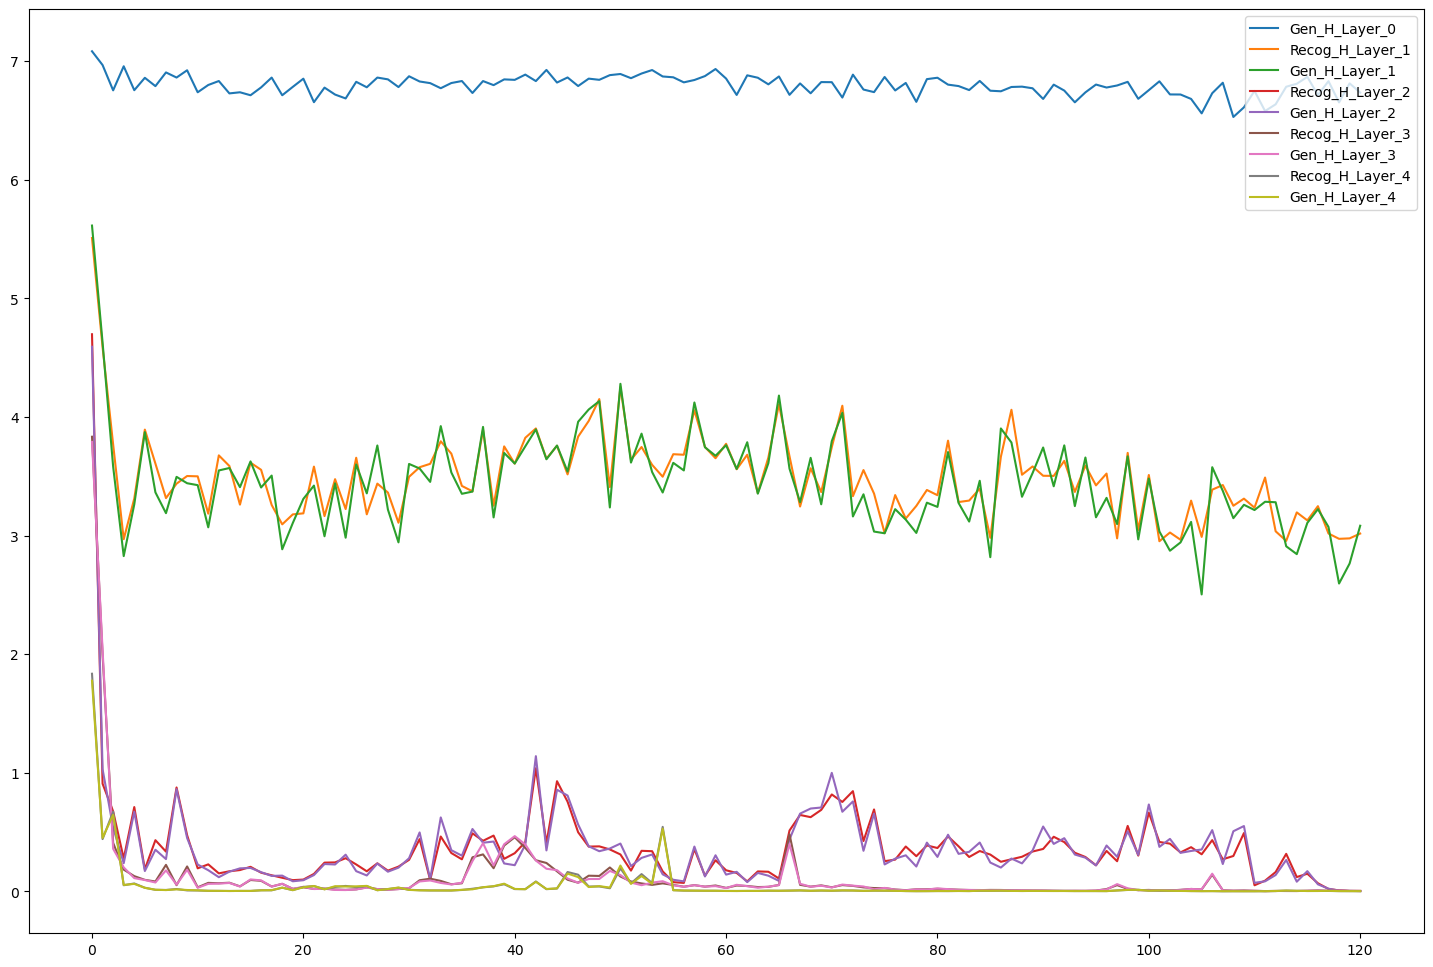

In [95]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_gen_batch['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_gen_batch['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_gen_batch['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

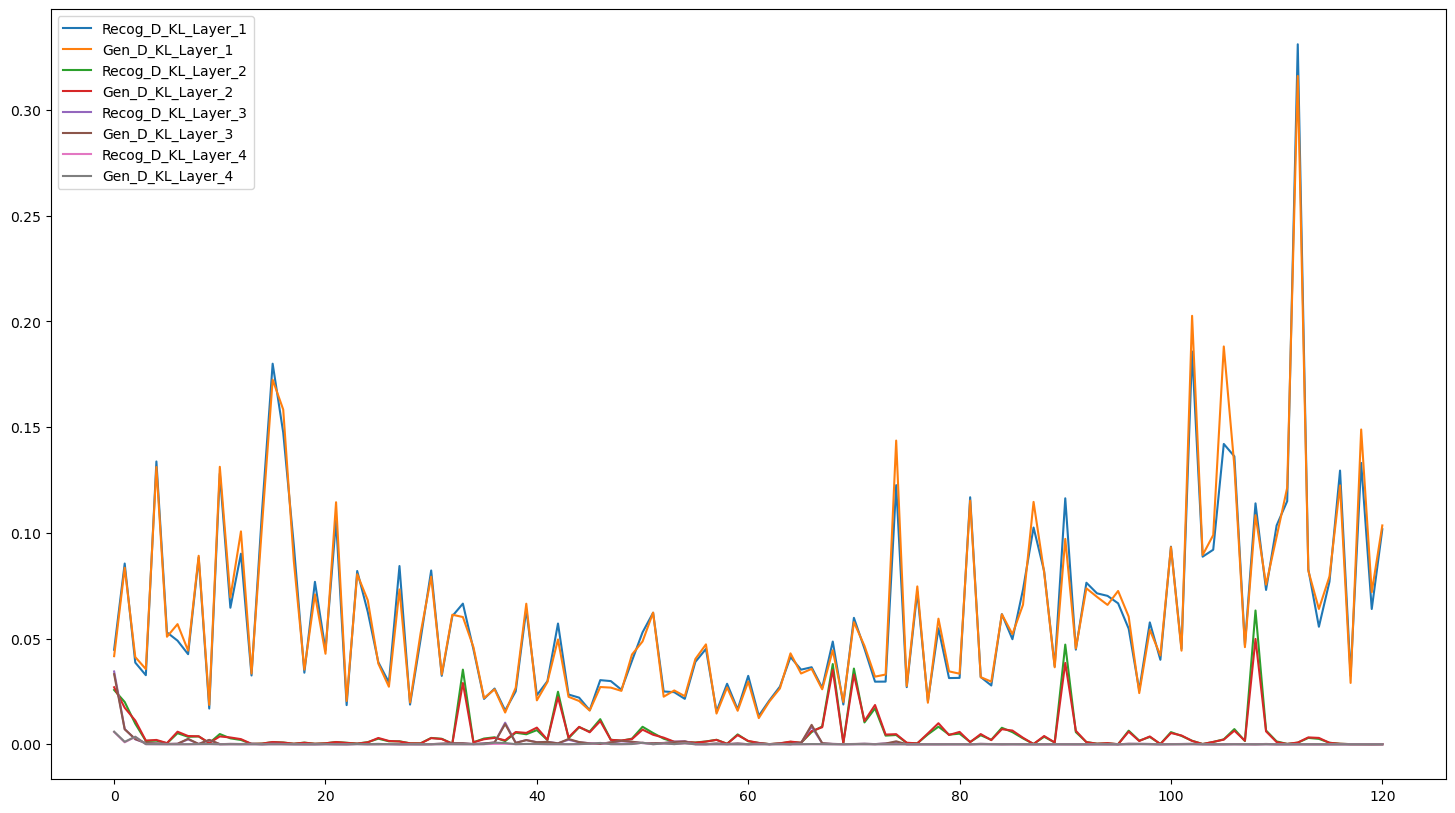

In [96]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_gen_batch['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_gen_batch['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

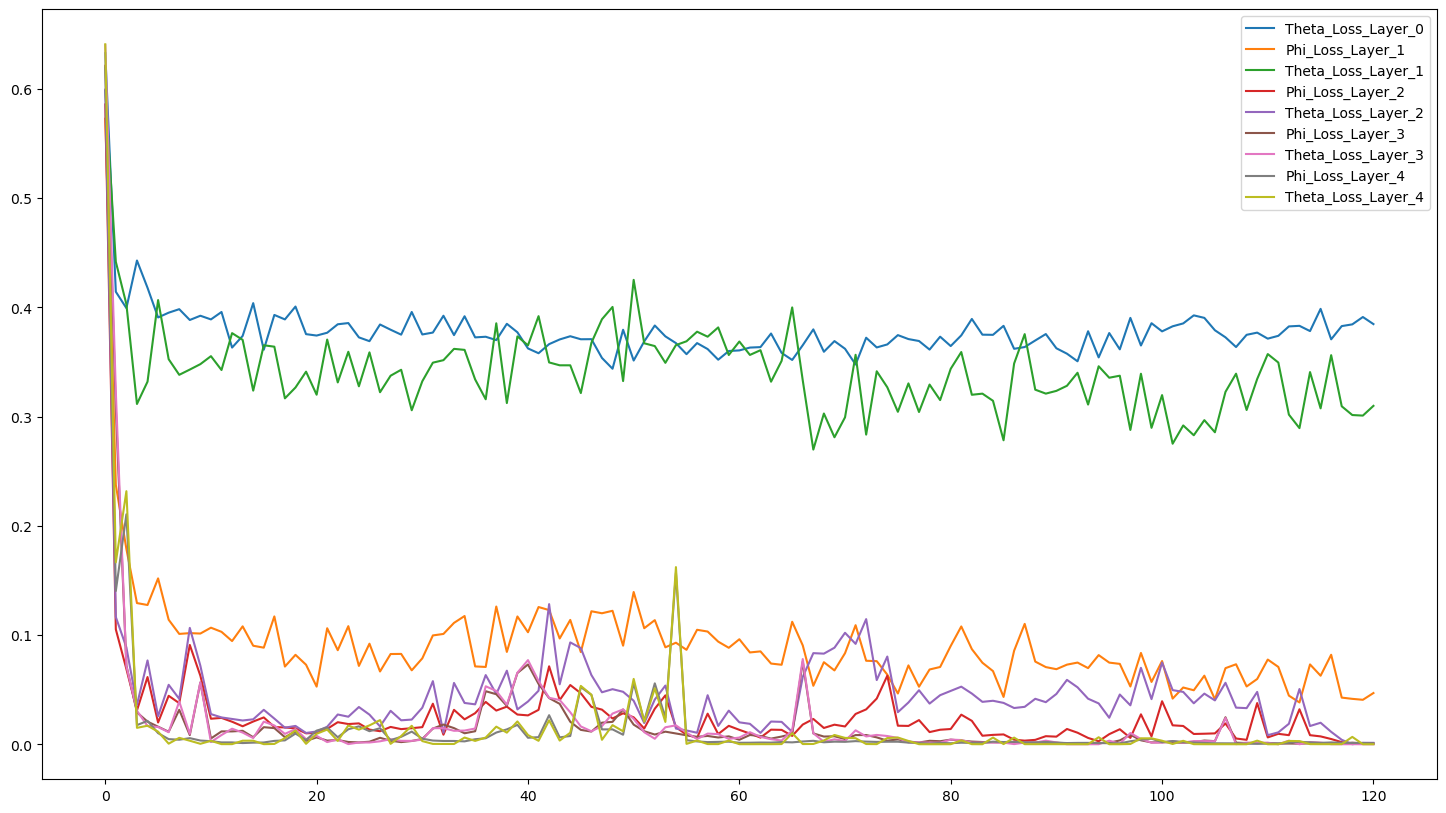

In [97]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_gen_batch['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_gen_batch['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_gen_batch['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()